In [218]:
import numpy as np
import os
import h5py
import tables
from scipy.io import loadmat
pi =np.pi
from keras.preprocessing import image

from utils.angles import deg2bit

In [9]:
x = np.random.rand(1000) * 2*pi

In [387]:
def y(x, p=0.5, eps=0.5):
    
    x_bin = np.random.binomial(1, p, x.shape)
    eps = np.random.normal(0, eps, x.shape)
    y = x*x_bin + (1-x_bin)*(x+pi) + eps
    #y = x  + eps
    return y

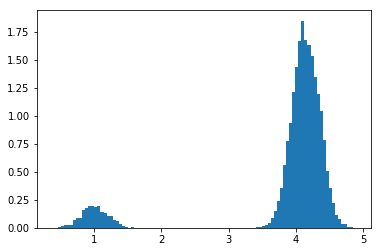

In [646]:
import matplotlib.pyplot as plt
%matplotlib inline 

x = np.ones([10000])
y_true_rad = y(x, p=0.1, eps=0.2)
y_true_deg = np.rad2deg(y_true_rad)
y_true_bit = deg2bit(y_true_deg)

plt.hist(y_true_rad, bins=100, normed=True)

plt.show()

In [579]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50

from models import vgg

from utils.losses import maad_from_deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, von_mises_log_likelihood_tf
from utils.losses import von_mises_log_likelihood_np, von_mises_neg_log_likelihood_keras


def blind_cvae(debug=False,
                  name='biternion_cnn',
                  add_noise=True,
                  n_samples=5,
                  z_size=8,
                  hlayer_size=128,
                  noise_std=1.0,
                  learning_rate=1.0e-3):
    
    X_input = Input(shape=[1], name='input_image')

    x = Dense(z_size*16, activation='relu', input_shape=[1])(X_input)
    x = Dense(z_size*4, activation='relu', input_shape=[1])(X_input)
    x = Dense(z_size, activation='relu', input_shape=[1])(X_input)
    
    def _sample_z(x):
        return K.random_normal(shape=K.shape(x), mean=0., stddev=noise_std)
    
    decoder_seq = Sequential(name='decoder')
    if add_noise:
        decoder_seq.add(Dense(hlayer_size, activation='relu', input_shape=[z_size*2]))
    else:
        decoder_seq.add(Dense(hlayer_size, activation='relu', input_shape=[hlayer_size]))
    
    decoder_seq.add(Dense(512, activation='relu', input_shape=[10+z_size]))
    decoder_seq.add(Dense(512, activation='relu'))

    decoder_mean = Sequential()
    decoder_mean.add(decoder_seq)
    decoder_mean.add((Dense(2, activation='linear')))
    decoder_mean.add(Lambda(lambda x: K.l2_normalize(x, axis=1), name='theta_mean'))

    decoder_kappa = Sequential()
    decoder_kappa.add(decoder_seq)
    decoder_kappa.add((Dense(1,  activation='linear')))
    decoder_kappa.add(Lambda(lambda x: K.abs(x), name='theta_kappa'))

    z_lst = []
    x_z_lst = []
    x_z_decoded_lst = []
    
    if add_noise:
        for k in range(0, n_samples):
            z_lst.append(Lambda(_sample_z)(x))
            x_z_lst.append(concatenate([x, z_lst[k]]))
            #x_z_lst.append(add([x, z_lst[k]]))
            #x_z_decoded_lst.append(decoder_kappa(x_z_lst[k]))
            x_z_decoded_lst.append(concatenate([decoder_mean(x_z_lst[k]), decoder_kappa(x_z_lst[k])]))

        if n_samples == 1:
            x_z_decoded_all = x_z_decoded_lst
        else:
            x_z_decoded_all = concatenate(x_z_decoded_lst)
        
    else:
        x_z_decoded_all = concatenate([decoder_mean(x), decoder_kappa(x)])
    
    model = Model(X_input, x_z_decoded_all )
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]

        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    def _loss(y_target, y_pred):
        
        theta_mean, theta_kappa = _unpack_preds(y_pred)
        theta_target = _unpack_target(y_target)
        
        loss = -von_mises_log_likelihood_tf(theta_target, theta_mean, theta_kappa)
        #loss = cosine_loss_tf(theta_target, theta_mean)   
        
        return loss
    
    def _mc_loss(y_target, y_pred):
        
        sample_likelihoods = []
        
        for sid in range(0, n_samples):
            
            sample_likelihoods.append(K.exp(von_mises_log_likelihood_tf(y_target, 
                                                                   y_pred[:, sid*3:sid*3+2], 
                                                                   y_pred[:, sid*3+2:sid*3+3])))
            
        
        mc_likelihood = -K.log(1.0e-20 + K.mean(concatenate(sample_likelihoods), axis=1))
                      
        return mc_likelihood
    
    opt = Adam(lr=learning_rate)
    
    if add_noise:
        if n_samples > 1:
            model.compile(optimizer=opt, loss=_mc_loss)
        else: 
            model.compile(optimizer=opt, loss=_loss)
    else:
        model.compile(optimizer=opt, loss=_loss)
        
    return model

In [642]:
model = biternion_disco(add_noise=True, 
                        learning_rate=1.0e-4,
                        hlayer_size=512,
                        noise_std=1.0e0,
                        z_size=4,
                        n_samples=10)

In [643]:
model.fit(x, y_true_bit, epochs=20)

Epoch 1/20
10000/10000 [==============================] - 19s 2ms/step - loss: 1.8390
Epoch 2/20
10000/10000 [==============================] - 10s 1ms/step - loss: 1.0514
Epoch 3/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.7138
Epoch 4/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6666
Epoch 5/20
10000/10000 [==============================] - 10s 1000us/step - loss: 0.6547
Epoch 6/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6279
Epoch 7/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6468
Epoch 8/20
10000/10000 [==============================] - 10s 999us/step - loss: 0.5897
Epoch 9/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6007
Epoch 10/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.6014: 0s - l
Epoch 11/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.5895
Epoch 12/20
10000/10000 [==============

In [644]:
mus_kappas = model.predict(x)
mu_rads = np.deg2rad(bit2deg(mus_kappas[:, 0:2]))
kappas = mus_kappas[:, 2]

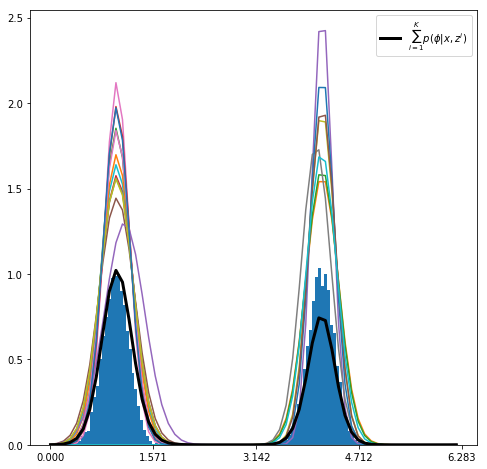

In [645]:
i = np.random.randint(0,100)

plt.figure(figsize=(8, 8))

xticks = [0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
#xticks_labels = ["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
plt.xticks(xticks)
#plt.xlabel(xticks_labels)

plt.hist(y_true_rad, bins=100, normed=True)

pdfs = []

for i in range(0, 20):
    x_vals = np.arange(0, 2*pi, 0.1)
    pdfs.append(vonmises.pdf(x_vals, loc=float(mu_rads[i]), kappa=float(kappas[i])))
    plt.plot(x_vals, pdfs[i])
    
pdf_acc = np.mean(np.asarray(pdfs), axis=0)

plt.plot(x_vals, pdf_acc, linewidth=3, color='black', label="$\sum_{i=1}^{K}{p(\phi|x, z^i)}$")

plt.legend(loc=1)

In [193]:
from scipy.stats import vonmises

def plot_vm_pdf(x, pdf, ax=None, y_true=None,):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    xticks = [0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
    xticks_labels = ["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)
    
    if y_true is not None:
        ax.axvline(y_true, c='red', label='ground truth')
    # ax.axvline(np.mean(pdf*x), label='mean')
    ax.plot(x, pdf) 
    ax.set_xlim((0, 2*np.pi))
    ax.set_ylim(0, 2.0)
    ax.legend(loc=1)
    
    return